## 0. Set up the environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# Set up the environment
import os
import numpy as np
import os
import sys
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
import math
import random
import statistics as stats
import scipy
import sklearn

from progressbar import ProgressBar

In [5]:
SEED = 4224
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [6]:
# Utility functions
def empty_list(n, fill_default = 0):
    ll = [fill_default] * n
    return ll

## 1. Load data

In [7]:
# Unzip the file containing training data
!unzip "/content/drive/MyDrive/AI_IN_BIOMEDICINE/PROJECT/training_set.zip"

Archive:  /content/drive/MyDrive/AI_IN_BIOMEDICINE/PROJECT/training_set.zip
  inflating: training_set/S001_128.mat  
  inflating: training_set/S001_128_ann.mat  
  inflating: training_set/S001_128_rpk.mat  
  inflating: training_set/S002_128.mat  
  inflating: training_set/S002_128_ann.mat  
 extracting: training_set/S002_128_rpk.mat  
  inflating: training_set/S003_128.mat  
  inflating: training_set/S003_128_ann.mat  
  inflating: training_set/S003_128_rpk.mat  
  inflating: training_set/S004_128.mat  
  inflating: training_set/S004_128_ann.mat  
 extracting: training_set/S004_128_rpk.mat  
  inflating: training_set/S005_128.mat  
  inflating: training_set/S005_128_ann.mat  
  inflating: training_set/S005_128_rpk.mat  
  inflating: training_set/S006_128.mat  
  inflating: training_set/S006_128_ann.mat  
  inflating: training_set/S006_128_rpk.mat  
  inflating: training_set/S007_128.mat  
  inflating: training_set/S007_128_ann.mat  
 extracting: training_set/S007_128_rpk.mat  
  infla

In [8]:
input_directory = '/content/training_set'

In [9]:
# N.B. Sort the file names in alphanumerical order to have perfect 
# correspomdence btw signals, rpeak pos and labels
filenames = []
for f in os.listdir(input_directory):
  filenames.append(f)

filenames = sorted(filenames)
print(filenames)

['S001_128.mat', 'S001_128_ann.mat', 'S001_128_rpk.mat', 'S002_128.mat', 'S002_128_ann.mat', 'S002_128_rpk.mat', 'S003_128.mat', 'S003_128_ann.mat', 'S003_128_rpk.mat', 'S004_128.mat', 'S004_128_ann.mat', 'S004_128_rpk.mat', 'S005_128.mat', 'S005_128_ann.mat', 'S005_128_rpk.mat', 'S006_128.mat', 'S006_128_ann.mat', 'S006_128_rpk.mat', 'S007_128.mat', 'S007_128_ann.mat', 'S007_128_rpk.mat', 'S008_128.mat', 'S008_128_ann.mat', 'S008_128_rpk.mat', 'S009_128.mat', 'S009_128_ann.mat', 'S009_128_rpk.mat', 'S010_128.mat', 'S010_128_ann.mat', 'S010_128_rpk.mat', 'S011_128.mat', 'S011_128_ann.mat', 'S011_128_rpk.mat', 'S012_128.mat', 'S012_128_ann.mat', 'S012_128_rpk.mat', 'S013_128.mat', 'S013_128_ann.mat', 'S013_128_rpk.mat', 'S014_128.mat', 'S014_128_ann.mat', 'S014_128_rpk.mat', 'S015_128.mat', 'S015_128_ann.mat', 'S015_128_rpk.mat', 'S016_128.mat', 'S016_128_ann.mat', 'S016_128_rpk.mat', 'S017_128.mat', 'S017_128_ann.mat', 'S017_128_rpk.mat', 'S018_128.mat', 'S018_128_ann.mat', 'S018_128_r

In [10]:
# Create an array containing the IDs of the subjects 
# n.b. This might be useful when ECG signal will be split into single heartbeats
subjects = []
for f in filenames:
  if "ann" not in f.lower() and "rpk" not in f.lower():
    subjects.append(f[0:4])

num_subjects = len(subjects)
print(subjects)

['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010', 'S011', 'S012', 'S013', 'S014', 'S015', 'S016', 'S017', 'S018', 'S019', 'S020', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029', 'S030', 'S031', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S041', 'S042', 'S043', 'S044', 'S045', 'S046', 'S047', 'S048', 'S049', 'S050', 'S051', 'S052', 'S053', 'S054', 'S055', 'S056', 'S057', 'S058', 'S059', 'S060', 'S061', 'S062', 'S063', 'S064', 'S065', 'S079', 'S080', 'S081', 'S082', 'S083', 'S084', 'S085', 'S086', 'S087', 'S088', 'S089', 'S090', 'S091', 'S092', 'S093', 'S094', 'S095', 'S096', 'S097', 'S098', 'S099', 'S100', 'S101', 'S102', 'S103', 'S104', 'S105', 'S106', 'S107', 'S108', 'S109', 'S110', 'S111', 'S112', 'S113', 'S114', 'S115', 'S116', 'S117', 'S118']


In [11]:
from scipy.io import loadmat

print('Loading data...')

# N.B. We have 3 different types of files:
# - ECG data
# - Annotations of R-peaks ('ann')
# - R-peaks positions ('rpk')
# We want to load these files in 3 different data structures (list of objects)
recordings = []
rpeaks = []
labels = []
# N.B. One object for each subject

# Scan through all the data in the input directory. Depending on the name of the 
# file choose the right list to store the data in the 3 data structures
for f in filenames:
  # Get the path for the current file
  g = os.path.join(input_directory, f)
  if 'ann' in f.lower() and os.path.isfile(g):
    label = loadmat(g)
    label = np.asarray(label['labels'])
    labels.append(label)
  elif 'rpk' in f.lower() and os.path.isfile(g):
    rpeak = loadmat(g)
    rpeak = np.asarray(rpeak['rpeaks'])
    rpeaks.append(rpeak)
  else:
    record = loadmat(g)
    record = np.asarray(record['ecg'])
    recordings.append(record)

num_records = len(recordings)


Loading data...


In [28]:
# Create a mask containing the sampling frequencies
# n.b. each ECG signal is measured over a time of 1800s
freqs = []
for rec in recordings:
  freqs.append(int(len(rec)/1800)) 

# Associate frequncies to subjects
subj_freqs = dict(zip(subjects, freqs))
print(subj_freqs)

{'S001': 128, 'S002': 128, 'S003': 128, 'S004': 128, 'S005': 128, 'S006': 128, 'S007': 128, 'S008': 128, 'S009': 128, 'S010': 128, 'S011': 128, 'S012': 128, 'S013': 128, 'S014': 128, 'S015': 128, 'S016': 128, 'S017': 128, 'S018': 128, 'S019': 128, 'S020': 128, 'S021': 128, 'S022': 128, 'S023': 128, 'S024': 128, 'S025': 128, 'S026': 128, 'S027': 128, 'S028': 128, 'S029': 128, 'S030': 128, 'S031': 128, 'S032': 128, 'S033': 128, 'S034': 128, 'S035': 128, 'S036': 128, 'S037': 128, 'S038': 128, 'S039': 128, 'S040': 128, 'S041': 128, 'S042': 128, 'S043': 128, 'S044': 128, 'S045': 128, 'S046': 128, 'S047': 128, 'S048': 128, 'S049': 128, 'S050': 128, 'S051': 128, 'S052': 128, 'S053': 128, 'S054': 128, 'S055': 128, 'S056': 128, 'S057': 128, 'S058': 128, 'S059': 128, 'S060': 128, 'S061': 128, 'S062': 128, 'S063': 128, 'S064': 128, 'S065': 128, 'S079': 250, 'S080': 250, 'S081': 250, 'S082': 250, 'S083': 250, 'S084': 250, 'S085': 250, 'S086': 250, 'S087': 250, 'S088': 250, 'S089': 250, 'S090': 250

In [12]:
# Tranform shape of rpeaks elements from (n,1) to (n,)
for i, elem in enumerate(rpeaks):
  rpeaks[i] = elem.reshape((len(elem),))

## 2. Labels encoding
- **0** for **'N'**: *normal sinus rhythm*
- **1** for **'S'**: *supraventricular beats* (**PACs**)
- **2** for **'V'**: *ventricular beats* (mostly **PVCs**)

In [27]:
num_classes = 3
classes_names = ["NSR", "PAC", "PVC"]
binary_labels = []

# Loop across the subjects
for i, subj_labels in enumerate(labels):
  # Initialize data structure to store the labels for each subject
  binary_labels.append(np.zeros(len(subj_labels), dtype=np.int32))
  # Loop across the beats for a subject
  for j, single_label in enumerate(subj_labels):
    if single_label == "N":
      binary_labels[i][j] = 0
    elif single_label == "S":
      binary_labels[i][j] = 1
    elif single_label == "V":
      binary_labels[i][j] = 2

## 3. Extract **Heartbeats** & Features about **R-R Intervals**
Consider an ECG signal and the correspondent R-peak positions.
Compute all the **middle points** between one peak and the following one. Each heartbeat is computed as the signal delimited by 2 consecutive middle points.

To extract RR features:
Following Sannino, De Pietro, we want to compute the following features:
- the **Pre-RR interval**, defined as the RR-interval between a
given heartbeat and the previous heartbeat;
- the **Post-RR interval**, defined as the RR-interval between a
given heartbeat and the following heartbeat;
- the **Local average RR interval**, defined as the average of the
10 RR-intervals within a sliding window covering the past
10 s;
- the **Global average RR interval**, defined as the average of
the 10 RR-intervals within a sliding window covering the
previous 5 min;

In [31]:
# Create the class heartbeat to store all the info for an heartbeat
class HeartBeat:
  ''' Remark:
  - Rpeak: position of the Rpeak of the current beat relative to the whole ECG signal
  - original_pos: position of the heartbeat in the original sequence, before any
                  deletion. It allows to reconstruct the ECG signal concatenating
                  the beats according the original order.
                  Same value for the same beat in the 2 leads. 
  ''' 
  # Constructor
  def __init__(self, subjectID, Rpeak, label, lead, frequency, original_pos, 
               pre_RR, post_RR, local_RR, global_RR, signal=None, aug=False):
    self.subjectID = subjectID
    self.Rpeak = Rpeak 
    self.label = label
    self.lead = lead
    self.frequency = frequency
    self.original_pos = original_pos
    self.pre_RR = pre_RR
    self.post_RR = post_RR
    self.local_RR = local_RR
    self.global_RR = global_RR
    self.aug = aug
    if signal is None:
      self.signal = []
    else:  
      self.signal = signal

  # Print method
  def __str__(self):
    return f'''HeartBeat({self.subjectID}, {self.frequency}, {self.Rpeak}, 
                         {self.label}, {self.lead}, {self.original_pos}, 
                         {self.pre_RR}, {self.post_RR}, {self.local_RR}, 
                         {self.global_RR}, {self.aug}, {self.signal})'''

In [32]:
def extract_RR_features(rpeaks, freq, local_win_seconds = 10, 
                        global_win_minutes = 5):
  pre_RR = []
  post_RR = []
  local_RR = []
  global_RR = []
  local_win = []
  global_win = []
  local_win_time = local_win_seconds*freq
  global_win_time = global_win_minutes*60*freq

  for i in range(len(rpeaks)):
    # PRE_RR
    if i-1 >= 0:
      pre_RR.append(rpeaks[i] - rpeaks[i-1])
    else:
      pre_RR.append(np.nan)

    # POST_RR
    if i+1 < len(rpeaks):
      post_RR.append(rpeaks[i+1] - rpeaks[i])
    else:
      post_RR.append(np.nan)

    # LOCAL_RR
    # Append in the back  
    local_win.append(np.where(np.isnan(pre_RR[i]), 0, pre_RR[i]))
    # Compute time spanned by the window
    local_time_span = sum(local_win)
    if local_time_span < local_win_time: # window is not full
      # average is nan
      local_RR.append(np.nan)
    elif local_time_span >= local_win_time:
      while local_time_span >= local_win_time:
        # Pop element in the front
        del local_win[0]
        # Recompute time_span
        local_time_span = local_win[-1] - local_win[0]
      # Compute the average
      local_RR.append(sum(local_win)/len(local_win))
      
    # GLOBAL_RR
    # Append in the back
    global_win.append(np.where(np.isnan(pre_RR[i]), 0, pre_RR[i]))
    # Compute time spanned by the window
    global_time_span = sum(global_win)
    if global_time_span < global_win_time: # window is not full
      # average is nan
      global_RR.append(np.nan)
    elif global_time_span >= global_win_time:
      while global_time_span >= global_win_time:
        # Pop element in the front
        del global_win[0]
        # Recompute time_span
        global_time_span = global_win[-1] - global_win[0]
      # Compute the average
      global_RR.append(sum(global_win)/len(global_win))
  
  return pre_RR, post_RR, local_RR, global_RR

In [33]:
def get_midpoints(rpeaks):
  '''Returns vector of midpoints between a couple of R-peaks'''
  dists = np.diff(rpeaks)
  midpoints = np.add(rpeaks[:-1], dists/2).astype(int)
  # Add a 0 at the beginning 
  midpoints = np.insert(midpoints, 0, 0)
  return midpoints

def get_subject_hbeats(signal, rpeaks, labels, subj_ID, freq):
  
  ''' Function to extract the heartbeats from a subject's data
  n.b. 1st and 2nd lead signals are separated into two different lists'''
  
  # Compute array of midpoints
  midpoints = get_midpoints(rpeaks)

  # Append final point of the signal at the end
  midpoints = np.append(midpoints, len(signal))

  # Extract the RR features for the subject
  pre_RR, post_RR, local_RR, global_RR = extract_RR_features(rpeaks, freq)

  # Iterate over the midpoints array to split the signal into heartbeats
  heartbeats_lead1 = [] # list of 'HeartBeat' objects
  heartbeats_lead2 = [] # list of 'HeartBeat' objects
  for i in range(len(rpeaks)):
    # Extract the 2 leads separately
    for l, signal_lead in enumerate(np.rollaxis(signal, 1)):
      # Define an heartbeat according to the midpoints
      curr_beat = signal_lead[midpoints[i]:midpoints[i+1]]
  
      # Store all the info in an object of class "heartbeat"
      curr_hbeat = HeartBeat(subjectID=subj_ID, signal=curr_beat, frequency=freq,
                             Rpeak=rpeaks[i], label=labels[i], lead=l+1,
                             pre_RR=pre_RR[i], post_RR=post_RR[i],
                             local_RR=local_RR[i], global_RR=global_RR[i],
                             original_pos=i)
      if l == 0: #1st lead
        heartbeats_lead1.append(curr_hbeat)
      elif l == 1: #2nd lead
        heartbeats_lead2.append(curr_hbeat)

  # # Get rid of 1st and last heartbeats (both the leads!)
  # heartbeats = heartbeats[2:-2]
  
  return heartbeats_lead1, heartbeats_lead2

Extract heartbeats for the **entire population** of subjects:

In [34]:
# Iterate the heartbeat extraction over all the subjects (and both the leads)
pbar = ProgressBar()
heartbeats_lead1 = []
heartbeats_lead2 = []
for i, (subj,freq) in pbar(enumerate(subj_freqs.items())):
  curr_hbeats_lead1, curr_hbeats_lead2 = get_subject_hbeats(recordings[i], 
                                                            rpeaks[i], 
                                                            binary_labels[i], 
                                                            subj, 
                                                            freq)
  heartbeats_lead1.extend(curr_hbeats_lead1)
  heartbeats_lead2.extend(curr_hbeats_lead2)

| |                                           #     | 104 Elapsed Time: 0:00:23


In [35]:
print(heartbeats_lead1[0])
print(heartbeats_lead2[0])
print(len(heartbeats_lead1))
print(len(heartbeats_lead2))
print(heartbeats_lead1 == heartbeats_lead2)

HeartBeat(S001, 128, 29, 
                         0, 1, 0, 
                         nan, 81, nan, 
                         nan, False, [ 0.     0.04   0.03   0.     0.03   0.09   0.18   0.14   0.3    0.24
  0.2    0.05  -0.02  -0.02  -0.05  -0.11  -0.11  -0.1   -0.14  -0.14
 -0.12  -0.13  -0.08  -0.16   0.19   0.825  1.46   2.095  1.455  0.815
  0.175 -0.42  -0.26  -0.29  -0.29  -0.31  -0.26  -0.29  -0.3   -0.32
 -0.31  -0.32  -0.31  -0.26  -0.27  -0.27  -0.28  -0.26  -0.25  -0.22
 -0.16  -0.14  -0.06  -0.02   0.05   0.1    0.16   0.15   0.13   0.12
  0.09   0.05   0.03   0.05   0.03   0.03   0.02   0.     0.02 ])
HeartBeat(S001, 128, 29, 
                         0, 2, 0, 
                         nan, 81, nan, 
                         nan, False, [ 0.08   0.07   0.1    0.06   0.06   0.03   0.1    0.21   0.18   0.26
  0.13   0.    -0.09  -0.08  -0.03  -0.03  -0.12  -0.11  -0.06  -0.1
 -0.08  -0.09  -0.08  -0.06  -0.16   0.31   0.945  0.305 -0.335 -0.975
 -1.615 -0.98  -0.345  0.28

### 3.1. **Delete heartbeats** whose length is out of physiologically plausible **limits**
**Limits:** Human BPM at rest are between 40 and 120 (considering a very large spectrum).
This implies that the length of an heartbeat should be roughly comprised between:
- At 128Hz: [0.5x128; 1.5x128] = [64; 192]
- At 250Hz: [0.5x250; 1.5x250] = [125; 375]

However, due to PAC we could have beats which are close each other. Therefore we **only consider the upper limit** for length.

Since we have lots of data, we can simply **remove** these istances.

In [36]:
# Find all the istances which are out of the physiological range
# N.B. We have to differentiate signals based on the sampling frequency!
out_of_range_idxs = []
for i,hb in enumerate(heartbeats_lead1):
  if hb.frequency == 128 and len(hb.signal) >= 192:
    out_of_range_idxs.append(i)
  elif hb.frequency == 250 and len(hb.signal) >= 375:
    out_of_range_idxs.append(i)
out_of_range_idxs = pd.Series(out_of_range_idxs)
print(out_of_range_idxs)

# Remove elements
# LEAD 1
print("Lead 1:")
print(len(heartbeats_lead1))
print(len(heartbeats_lead1) - len(out_of_range_idxs))
for idx in sorted(out_of_range_idxs, reverse=True):
  del heartbeats_lead1[idx]
print(len(heartbeats_lead1))

# LEAD 2
print("Lead 2:")
print(len(heartbeats_lead2))
print(len(heartbeats_lead2) - len(out_of_range_idxs))
for idx in sorted(out_of_range_idxs, reverse=True):
  del heartbeats_lead2[idx]
print(len(heartbeats_lead2))

0        5199
1        5200
2        8898
3       36346
4       36347
        ...  
136    234921
137    234922
138    234930
139    234931
140    237838
Length: 141, dtype: int64
Lead 1:
244336
244195
244195
Lead 2:
244336
244195
244195


### 3.2. Remove heartbeats whose RR features are **'Nan'**
N.B. Since we are taking the average across windows of 5 min of beats, we are going to remove the first 5 minutes of every ECG signal.

In [37]:
nan_idxs = []
for i,hb in enumerate(heartbeats_lead1):
  if np.isnan(hb.pre_RR) or np.isnan(hb.post_RR) or np.isnan(hb.local_RR) or np.isnan(hb.global_RR):
    nan_idxs.append(i)
nan_idxs = pd.Series(nan_idxs)
print(nan_idxs)

# Remove elements
# LEAD 1
print("Lead 1:")
print(len(heartbeats_lead1))
print(len(heartbeats_lead1) - len(nan_idxs))
for idx in sorted(nan_idxs, reverse=True):
  del heartbeats_lead1[idx]
print(len(heartbeats_lead1))

# LEAD 2
print("Lead 2:")
print(len(heartbeats_lead2))
print(len(heartbeats_lead2) - len(nan_idxs))
for idx in sorted(nan_idxs, reverse=True):
  del heartbeats_lead2[idx]
print(len(heartbeats_lead2))

0             0
1             1
2             2
3             3
4             4
          ...  
44965    242534
44966    242545
44967    242563
44968    242709
44969    244194
Length: 44970, dtype: int64
Lead 1:
244195
199225
199225
Lead 2:
244195
199225
199225


N.B. Create a unique heartbeats vector containing the 2 leads to avoid code replication

In [38]:
heartbeats = heartbeats_lead1 + heartbeats_lead2
num_hbs = len(heartbeats)
num_hbs

398450

## 4. Signal Preprocessing

### 4.1. **Standardize** ECG signals 
**Standardize** data using the **Z-score** approach, *one heartbeat at the time*!! 

N.B. Standardization happens in Data Augmentation phase!!!

In [39]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# Function that, given mean, sd values, performs standardization
def Zscore_Standardization(data, mean, sd):
  ''' Data: one ECG signal. '''
  return (data - mean) / sd

In [40]:
pbar = ProgressBar()
for i in pbar(range(len(heartbeats))):
  heartbeats[i].signal = Zscore_Standardization(heartbeats[i].signal,
                                                np.mean(heartbeats[i].signal),
                                                np.std(heartbeats[i].signal))

100% (398450 of 398450) |################| Elapsed Time: 0:00:16 Time:  0:00:16


### 4.2. **Heartbeats Resampling**
Resample all the heartbeat signals to a fixed length using FFT.

**N.B.** Resampling is more effective if the selected length is not *too small*, otherwise some information can be lost. 

In order to have a consistent representation of the resampled signal we consider as final length a value close to the **median** heartbeat length.

In [41]:
from scipy import signal
from progressbar import ProgressBar
pbar = ProgressBar()

final_len = 128

heartbeats_res = empty_list(len(heartbeats))
for i, hb in pbar(enumerate(heartbeats)):
  signal_res = scipy.signal.resample(hb.signal, final_len)
  hb.signal = signal_res 
  heartbeats_res[i] = hb

for hb in heartbeats_res:
  if len(hb.signal) != final_len:
    print(len(hb.signal))

| |          #                                   | 398449 Elapsed Time: 0:00:19


### 4.3. **Denoise** ECG signals using **Bandpass Filter**



In [42]:
from scipy.signal import butter, lfilter, filtfilt

def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data)
        return y

In [43]:
# Apply Bandpass filter to each signal
pbar = ProgressBar()

heartbeats_denoise = empty_list(len(heartbeats_res))
for i, hb in pbar(enumerate(heartbeats_res)):
  signal_denoise = bandpass_filter(hb.signal, 1, 47, 500, 3)
  hb.signal = signal_denoise 
  heartbeats_denoise[i] = hb

| |                                        #     | 398449 Elapsed Time: 0:01:46


In [44]:
heartbeats = heartbeats_denoise
heartbeats_lead1 = []
heartbeats_lead2 = []
# Extract labels
hbs_labels = []
for hb in heartbeats:
  if hb.lead == 1:
    heartbeats_lead1.append(hb)
    hbs_labels.append(hb.label)
  elif hb.lead == 2:
    heartbeats_lead2.append(hb)

## 5. Organize data for model training

### 5.1. **One-Hot-Encoding** of labels 

In [45]:
from sklearn.preprocessing import OneHotEncoder

# Transform labels vector into np.array
hbs_labels = np.asarray(hbs_labels)
hbs_labels = np.expand_dims(hbs_labels, 1)

onehot_encoder = OneHotEncoder(sparse=False)
hbs_labels = onehot_encoder.fit_transform(hbs_labels)

### 5.2. Split in **Train**, **Validation** & **Test**

Split Training and Test sets

In [46]:
from sklearn.model_selection import train_test_split

heartbeats_lead1_train, heartbeats_lead1_test, heartbeats_lead2_train, heartbeats_lead2_test, labels_train, labels_test = train_test_split(heartbeats_lead1,
                                                                                                                                           heartbeats_lead2,
                                                                                                                                           hbs_labels,
                                                                                                                                           test_size=0.15,
                                                                                                                                           random_state=SEED,
                                                                                                                                           shuffle=True,
                                                                                                                                           stratify=hbs_labels)

In [47]:
heartbeats_lead1_train, heartbeats_lead1_valid, heartbeats_lead2_train, heartbeats_lead2_valid, labels_train, labels_valid = train_test_split(heartbeats_lead1_train,
                                                                                                                                              heartbeats_lead2_train,
                                                                                                                                              labels_train,
                                                                                                                                              test_size=0.25,
                                                                                                                                              random_state=SEED,
                                                                                                                                              shuffle=True,
                                                                                                                                              stratify=labels_train)

In [48]:
# Compute labels frequency in training, valid and test sets
values, counts = np.unique(onehot_encoder.inverse_transform(labels_train), return_counts=True)
print(dict(zip(values, counts)))

values, counts = np.unique(onehot_encoder.inverse_transform(labels_valid), return_counts=True)
print(dict(zip(values, counts)))

values, counts = np.unique(onehot_encoder.inverse_transform(labels_test), return_counts=True)
print(dict(zip(values, counts)))

{0: 118137, 1: 4831, 2: 4037}
{0: 39380, 1: 1610, 2: 1346}
{0: 27797, 1: 1137, 2: 950}


### 5.3. Weighting 
To solve the **class imbalance** problem we compute for each class a weight which is inversely proportional to the frequency of elements of that class.

In [49]:
from sklearn.utils.class_weight import compute_class_weight

def calculating_class_weights(labels):
    number_dim = np.shape(labels)[1] # dimensions of one-hot-enoding
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight(class_weight='balanced', 
                                          classes=np.unique(labels[:,i]), 
                                          y=labels[:,i])
    return weights

class_weights = calculating_class_weights(labels_train)

keys = np.arange(0,3,1)
weight_dictionary_fold = dict(zip(keys, class_weights.T[1]))
weight_dictionary_fold

{0: 0.5375326950912923, 1: 13.144794038501345, 2: 15.730121377260343}

### 5.4. Extract **signal**, **RR_features** and **labels** from the 'HeartBeat' objects

N.B. The 2 leads should be recombined to get an array of shape (128,2)

In [50]:
def extract_from_HeartBeats(hbs_lead1, hbs_lead2):
  pbar = ProgressBar()
  # Initialize data structures
  hbs_signals = empty_list(len(hbs_lead1))
  hbs_RRfeatures = pd.DataFrame(index=range(len(hbs_lead1)),
      columns=["pre_RR","post_RR","local_RR","global_RR"])
  hbs_labels = np.empty((len(hbs_lead1),1))
  hbs_aug = np.empty((len(hbs_lead1)))
  # Iterate across heartbeats and extract
  for i in pbar(range(len(hbs_lead1))):
    new_signal = np.c_[hbs_lead1[i].signal,
                       hbs_lead2[i].signal]
    hbs_signals[i] = new_signal

    # new_RRfeat = {"pre_RR": hbs_lead1[i].pre_RR,
    #               "post_RR": hbs_lead1[i].post_RR,
    #               "local_RR": hbs_lead1[i].local_RR,
    #               "global_RR": hbs_lead1[i].global_RR}
    new_RRfeat = [hbs_lead1[i].pre_RR, hbs_lead1[i].post_RR,
                  hbs_lead1[i].local_RR, hbs_lead1[i].global_RR]
    hbs_RRfeatures.loc[i,:] = new_RRfeat

    hbs_labels[i] = hbs_lead1[i].label
    hbs_aug[i] = hbs_lead1[i].aug
  
  return hbs_signals, hbs_RRfeatures, hbs_labels, hbs_aug


In [51]:
# TRAIN (original)
signals_train, RRfeatures_train, labels_train, _ = extract_from_HeartBeats(heartbeats_lead1_train, 
                                                                           heartbeats_lead2_train)

# VALIDATION (original)
signals_valid, RRfeatures_valid, labels_valid, _ = extract_from_HeartBeats(heartbeats_lead1_valid, 
                                                                           heartbeats_lead2_valid)

# TEST (original)
signals_test, RRfeatures_test, labels_test, _ = extract_from_HeartBeats(heartbeats_lead1_test, 
                                                                        heartbeats_lead2_test)

100% (127005 of 127005) |################| Elapsed Time: 0:00:17 Time:  0:00:17
100% (42336 of 42336) |##################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (29884 of 29884) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


Transform lists of np.ndarray's into np.ndarray with an additional axis

In [52]:
signals_train = np.asarray(signals_train)
RRfeatures_train = np.asarray(RRfeatures_train)

signals_valid = np.asarray(signals_valid)
RRfeatures_valid = np.asarray(RRfeatures_valid)

signals_test = np.asarray(signals_test)
RRfeatures_test = np.asarray(RRfeatures_test)

Perform **One-Hot-Encoding** of the labels extracted for the augmented datasets.

In [53]:
labels_train = onehot_encoder.fit_transform(labels_train)

labels_valid = onehot_encoder.fit_transform(labels_valid)

labels_test = onehot_encoder.fit_transform(labels_test)

## 6. Model Definition and Training

In [17]:
import tensorflow as tf
from tensorflow import keras

from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, BatchNormalization, concatenate
from keras.models import Model, load_model
from keras import callbacks
from keras_preprocessing.sequence import pad_sequences

import keras.backend as K
K.set_image_data_format('channels_last')

In [20]:
input_shape = (128,2)
num_classes = 3
batchsize = 64

### 6.1. **ResNet** trained on the **Original Training set** using **Class Weighting** to reduce class imbalance

In [16]:
# ResNet model definition 
def ResBs_Conv(block_input, num_filters): 
   
    # 0. Filter Block input and BatchNormalization
    block_input = Conv1D(num_filters, kernel_size=7, strides = 2,  padding = 'same')(block_input) 
    block_input = BatchNormalization()(block_input)

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)  
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout)
    norm2 = BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

def ResBs_Identity(block_input, num_filters): 

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)    
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

def resnet(N=8, ch=2, win_len=128, classes=3): 
    ecg_input = Input(shape=(win_len, ch), name='ecg_signal') 

    ResNet = Conv1D(filters=64, kernel_size=15, padding = 'same')(ecg_input) 
    ResNet = BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = MaxPooling1D(pool_size=2, strides = 2)(ResNet)
    
    # B.5 ResBs (x8) blocks
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M= int((N-2)/2)
    for i in range(M): 
        filters = filters*2
        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    ResNet = Flatten()(ResNet) 

    # Sigmoid activation function on the last layer
    ResNet = Dense(classes, activation='softmax',  name='softmax_classifier')(ResNet)

    # Finally the model is composed by connecting inputs to outputs: 
    model = Model(inputs=[ecg_input],outputs=ResNet)
    return model


In [21]:
resNet_model = resnet(N=8, win_len=input_shape[0], 
                      ch=input_shape[1], classes=num_classes)

resNet_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.01),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'Precision', 'Recall' ]
)

In [23]:
resNet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ecg_signal (InputLayer)        [(None, 128, 2)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 128, 64)      1984        ['ecg_signal[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 64)     256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 128, 64)      0           ['batch_normalization[0][0]']

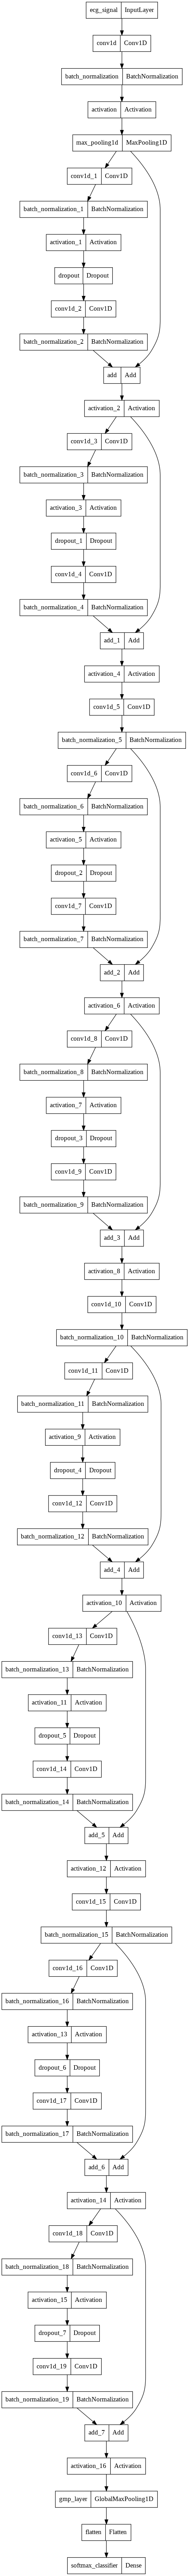

In [22]:
# model graph
tf.keras.utils.plot_model(
    resNet_model,
    # to_file="resNet_model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [91]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor="val_loss",
                           patience=20,
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=8, min_lr=0.0001, verbose=1)

clbks = [early_stop, reduce_lr]

In [92]:
history = resNet_model.fit(
    x = signals_train,
    y = labels_train,
    validation_data=(signals_valid, labels_valid),
    steps_per_epoch=(len(signals_train)/batchsize),
    batch_size = batchsize,
    epochs = 50,
    callbacks = clbks,
    class_weight = weight_dictionary_fold
).history

Epoch 1/50
1984/1984 [==============================] - 94s 43ms/step - loss: 1.2317 - accuracy: 0.7954 - precision: 0.8319 - recall: 0.7548 - val_loss: 61.4617 - val_accuracy: 0.5049 - val_precision: 0.5053 - val_recall: 0.4931 - lr: 0.0100
Epoch 2/50
1984/1984 [==============================] - 83s 42ms/step - loss: 0.5628 - accuracy: 0.9068 - precision: 0.9173 - recall: 0.8957 - val_loss: 0.1893 - val_accuracy: 0.9329 - val_precision: 0.9369 - val_recall: 0.9300 - lr: 0.0100
Epoch 3/50
1984/1984 [==============================] - 85s 43ms/step - loss: 0.4632 - accuracy: 0.9189 - precision: 0.9272 - recall: 0.9109 - val_loss: 1.2489 - val_accuracy: 0.5419 - val_precision: 0.5488 - val_recall: 0.5282 - lr: 0.0100
Epoch 4/50
1984/1984 [==============================] - 83s 42ms/step - loss: 0.4354 - accuracy: 0.9241 - precision: 0.9323 - recall: 0.9170 - val_loss: 0.6123 - val_accuracy: 0.7857 - val_precision: 0.8085 - val_recall: 0.7613 - lr: 0.0100
Epoch 5/50
1984/1984 [=============

In [94]:
# # Save trained model
# model_directory = '/content/drive/MyDrive/AI_IN_BIOMEDICINE/PROJECT/Models/'
# filename = 'resNet_trained'
# filename_chosen = os.path.join(model_directory, filename)
# resNet_model.save(filename_chosen + '.h5')

### 6.2. **ResNet** + **Wide features** trained on the **Augmented Training set**

In [75]:
# model integrating deep + wide 
def resnet_deep_wide(N=4, ch=2, win_len=128, num_wide_features=4, classes=3): 
    # A. Wide features
    wide_input = Input(shape= (num_wide_features, ), name = 'wide_features')
    wide_branch = Dense(4, activation='relu')(wide_input)
    wide_branch = Dense(2, activation='relu')(wide_branch)

    # B. ECG window input of shape (batch_size,  WINDOW_LEN, CHANNELS)
    ecg_input = Input(shape=(win_len, ch), name='ecg_signal') 

    ResNet = Conv1D(filters=64,kernel_size=15, padding = 'same')(ecg_input) 
    ResNet = BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = MaxPooling1D(pool_size=2, strides = 2)(ResNet)
    
    # B.5 ResBs (x8) blocks
    # The number of filters starts from 64 and doubles every two blocks
    
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M= int((N-2)/2)
    for i in range(M): 
        filters = filters*2

        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    ResNet = Flatten()(ResNet)

    shared_path = concatenate([ResNet, wide_branch], name='concat_layer')
    shared_path = Dense(classes, activation='softmax', name='softmax_classifier')(shared_path)
   
    # Finally the model is composed by connecting inputs to outputs: 
    model = Model(inputs=[ecg_input,  wide_input],outputs=shared_path)

    return model

In [76]:
resNet_deep_wide_model = resnet_deep_wide(N=8, ch=2, win_len=128, num_wide_features= 4, classes=3)

In [ ]:
resNet_deep_wide_model.summary()

In [ ]:
# tf.keras.utils.plot_model(
#     resNet_deep_wide_model,
#     # to_file="resNet_model.png",
#     show_shapes=False,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
# )

In [78]:
resNet_deep_wide_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.01),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'Precision', 'Recall']
)

In [79]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor="val_loss",
                           patience=20,
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=8, min_lr=0.0001, verbose=1)

clbks = [early_stop, reduce_lr]

In [81]:
history = resNet_deep_wide_model.fit(
    x = [signals_train, RRfeatures_train.astype('float64')],
    y = labels_train,
    validation_data=([signals_valid, RRfeatures_valid.astype('float64')], labels_valid),
    steps_per_epoch=(len(signals_train)/batchsize),
    batch_size = batchsize,
    epochs = 40,
    class_weight = weight_dictionary_fold,
    callbacks = clbks
).history

Epoch 1/40
1984/1984 [==============================] - 93s 45ms/step - loss: 1.1044 - accuracy: 0.8875 - precision: 0.9020 - recall: 0.8643 - val_loss: 0.6366 - val_accuracy: 0.8463 - val_precision: 0.8495 - val_recall: 0.8326 - lr: 0.0100
Epoch 2/40
1984/1984 [==============================] - 87s 44ms/step - loss: 0.5508 - accuracy: 0.9282 - precision: 0.9347 - recall: 0.9206 - val_loss: 0.3274 - val_accuracy: 0.9290 - val_precision: 0.9384 - val_recall: 0.9204 - lr: 0.0100
Epoch 3/40
1984/1984 [==============================] - 87s 44ms/step - loss: 0.5106 - accuracy: 0.9299 - precision: 0.9358 - recall: 0.9235 - val_loss: 0.2131 - val_accuracy: 0.9524 - val_precision: 0.9562 - val_recall: 0.9473 - lr: 0.0100
Epoch 4/40
1984/1984 [==============================] - 88s 44ms/step - loss: 0.4306 - accuracy: 0.9420 - precision: 0.9466 - recall: 0.9372 - val_loss: 0.1187 - val_accuracy: 0.9725 - val_precision: 0.9737 - val_recall: 0.9713 - lr: 0.0100
Epoch 5/40
1984/1984 [==============

In [95]:
# # Save trained model
# model_directory = '/content/drive/MyDrive/AI_IN_BIOMEDICINE/PROJECT/Models/'
# filename = 'wide_resNet_trained'
# filename_chosen = os.path.join(model_directory, filename)
# resNet_deep_wide_model.save(filename_chosen + '.h5')

### 6.3. Load Pre-Trained Models

ResNet model

In [54]:
resNet_model = load_model("/content/drive/MyDrive/AI_IN_BIOMEDICINE/PROJECT/Models/resNet_trained.h5")

Wide ResNet model

In [90]:
resNet_deep_wide_model = load_model("/content/drive/MyDrive/AI_IN_BIOMEDICINE/PROJECT/Models/wide_resNet_trained_DEFINITIVA.h5")

## 7. Model Evaluation

### 7.1. Learning Performances on Training & Validation

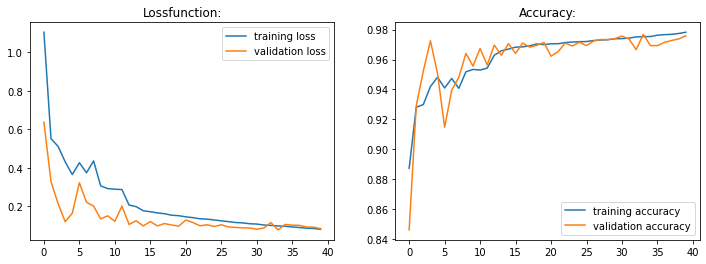

In [82]:
# #plot performances
# plt.figure(figsize = (12,4))
# plt.subplot(1,2,1)
# plt.plot(history['loss'], label="training loss")
# plt.plot(history['val_loss'], label="validation loss")
# plt.title('Lossfunction:')
# plt.legend()

# plt.subplot(1,2,2)
# plt.plot(history['accuracy'], label="training accuracy")
# plt.plot(history['val_accuracy'], label="validation accuracy")
# plt.title('Accuracy:')
# plt.legend()

### 7.2. Prediction on the **Original Test set**

#### 7.2.1. ResNet model

Predict labels for the test set

In [85]:
pred = resNet_model.predict(signals_test)
print(pred[:10])

[[9.9999917e-01 8.2171971e-07 6.4692293e-11]
 [5.5989277e-01 4.3614778e-01 3.9594313e-03]
 [9.9992895e-01 7.1034301e-05 2.0678329e-11]
 [9.9947041e-01 5.2964309e-04 3.1235198e-11]
 [9.7531611e-01 2.4681004e-02 2.9154678e-06]
 [1.9015870e-07 3.7260061e-06 9.9999607e-01]
 [1.0000000e+00 1.9341407e-17 3.5045429e-20]
 [9.9987161e-01 1.2834564e-04 9.8179094e-14]
 [9.9999726e-01 2.7211815e-06 4.2422666e-08]
 [9.9999976e-01 2.8346915e-07 1.3850046e-13]]


In [86]:
predicted_class = np.argmax(pred, axis=-1)
predicted_class[:10]

array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0])

In [87]:
y_pred = np.zeros((predicted_class.size, predicted_class.max()+1))
y_pred[np.arange(predicted_class.size), predicted_class] = 1
y_pred[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [88]:
cm = sklearn.metrics.confusion_matrix(np.argmax(labels_test,axis=1),np.argmax(pred,axis=1))
cm

array([[27347,   399,    51],
       [   65,  1037,    35],
       [   26,    24,   900]])

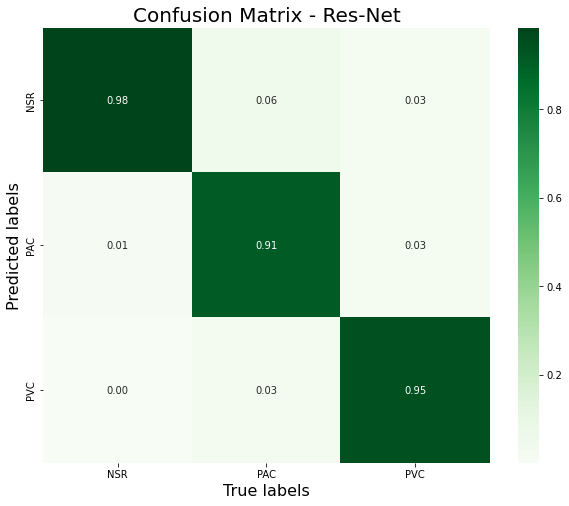

In [64]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(classes_names), yticklabels=list(classes_names),
            cmap="Greens", annot=True, fmt='.2f')
plt.xlabel('True labels', fontsize=16)
plt.ylabel('Predicted labels', fontsize=16)
plt.title('Confusion Matrix - Res-Net', fontsize=20)
plt.show()

Compute standard metrics

In [89]:
metrics = sklearn.metrics.classification_report(y_true=np.argmax(labels_test,axis=1),
                                                y_pred=np.argmax(pred,axis=1),
                                                output_dict=True)
metrics

{'0': {'precision': 0.996683431737007,
  'recall': 0.9838112026477678,
  'f1-score': 0.9902054856522133,
  'support': 27797},
 '1': {'precision': 0.7102739726027397,
  'recall': 0.9120492524186455,
  'f1-score': 0.7986137851366961,
  'support': 1137},
 '2': {'precision': 0.9127789046653144,
  'recall': 0.9473684210526315,
  'f1-score': 0.9297520661157025,
  'support': 950},
 'accuracy': 0.9799223664837371,
 'macro avg': {'precision': 0.8732454363350204,
  'recall': 0.9477429587063483,
  'f1-score': 0.9061904456348707,
  'support': 29884},
 'weighted avg': {'precision': 0.9831190877484589,
  'recall': 0.9799223664837371,
  'f1-score': 0.9809941848877297,
  'support': 29884}}

#### 7.2.2. Wide ResNet model

In [91]:
pred = resNet_deep_wide_model.predict([signals_test, RRfeatures_test.astype("float64")])

In [92]:
predicted_class = np.argmax(pred, axis=-1)

In [93]:
y_pred = np.zeros((predicted_class.size, predicted_class.max()+1))
y_pred[np.arange(predicted_class.size), predicted_class] = 1

In [94]:
cm = sklearn.metrics.confusion_matrix(np.argmax(labels_test,axis=1),np.argmax(pred,axis=1))
cm

array([[27323,   422,    52],
       [   41,  1060,    36],
       [   18,    24,   908]])

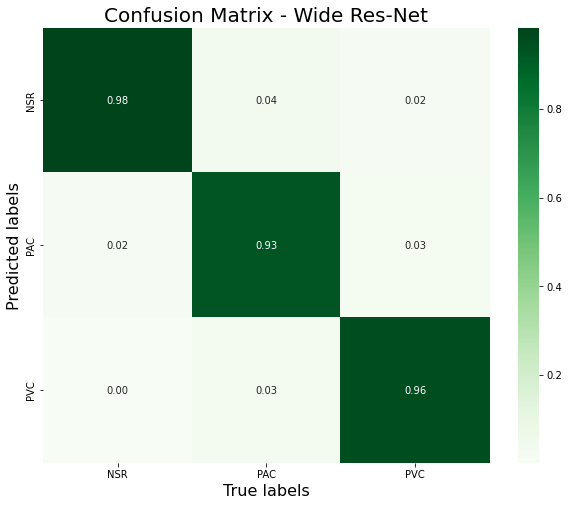

In [95]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(classes_names), yticklabels=list(classes_names),
            cmap="Greens", annot=True, fmt='.2f')
plt.xlabel('True labels', fontsize=16)
plt.ylabel('Predicted labels', fontsize=16)
plt.title('Confusion Matrix - Wide Res-Net', fontsize=20)
plt.show()

Compute standard metrics

In [96]:
metrics = sklearn.metrics.classification_report(y_true=np.argmax(labels_test,axis=1),
                                                y_pred=np.argmax(pred,axis=1),
                                                output_dict=True)
metrics

{'0': {'precision': 0.9978452998320064,
  'recall': 0.9829478001223153,
  'f1-score': 0.9903405280994582,
  'support': 27797},
 '1': {'precision': 0.703851261620186,
  'recall': 0.9322779243623571,
  'f1-score': 0.8021188043889519,
  'support': 1137},
 '2': {'precision': 0.9116465863453815,
  'recall': 0.9557894736842105,
  'f1-score': 0.9331963001027749,
  'support': 950},
 'accuracy': 0.9801566055414268,
 'macro avg': {'precision': 0.8711143825991913,
  'recall': 0.9570050660562943,
  'f1-score': 0.908551877530395,
  'support': 29884},
 'weighted avg': {'precision': 0.9839194532499178,
  'recall': 0.9801566055414268,
  'f1-score': 0.9813626430621241,
  'support': 29884}}

 Training vs Validation vs Test

In [97]:
pred = resNet_deep_wide_model.predict([signals_valid, RRfeatures_valid.astype("float64")])

In [98]:
predicted_class = np.argmax(pred, axis=-1)

In [99]:
y_pred = np.zeros((predicted_class.size, predicted_class.max()+1))
y_pred[np.arange(predicted_class.size), predicted_class] = 1

In [100]:
metrics = sklearn.metrics.classification_report(y_true=np.argmax(labels_valid,axis=1),
                                                y_pred=np.argmax(pred,axis=1),
                                                output_dict=True)
metrics

{'0': {'precision': 0.999948452279698,
  'recall': 0.985195530726257,
  'f1-score': 0.9925171721306233,
  'support': 39380},
 '1': {'precision': 0.7537735849056604,
  'recall': 0.9925465838509316,
  'f1-score': 0.8568364611260053,
  'support': 1610},
 '2': {'precision': 0.9484827099505999,
  'recall': 0.9985141158989599,
  'f1-score': 0.9728555917480999,
  'support': 1346},
 'accuracy': 0.9858985260770975,
 'macro avg': {'precision': 0.9007349157119862,
  'recall': 0.9920854101587162,
  'f1-score': 0.9407364083349096,
  'support': 42336},
 'weighted avg': {'precision': 0.9889503791115392,
  'recall': 0.9858985260770975,
  'f1-score': 0.9867322507419161,
  'support': 42336}}

In [101]:
pred = resNet_deep_wide_model.predict([signals_train, RRfeatures_train.astype("float64")])

In [102]:
predicted_class = np.argmax(pred, axis=-1)

In [103]:
y_pred = np.zeros((predicted_class.size, predicted_class.max()+1))
y_pred[np.arange(predicted_class.size), predicted_class] = 1

In [104]:
metrics = sklearn.metrics.classification_report(y_true=np.argmax(labels_train,axis=1),
                                                y_pred=np.argmax(pred,axis=1),
                                                output_dict=True)
metrics

{'0': {'precision': 0.9999828165407978,
  'recall': 0.9852036195264819,
  'f1-score': 0.9925382043935053,
  'support': 118137},
 '1': {'precision': 0.7495297805642633,
  'recall': 0.9898571724280687,
  'f1-score': 0.853090714476853,
  'support': 4831},
 '2': {'precision': 0.9522909777987718,
  'recall': 0.9987614565271241,
  'f1-score': 0.9749727965179542,
  'support': 4037},
 'accuracy': 0.9858115822211724,
 'macro avg': {'precision': 0.9006011916346109,
  'recall': 0.9912740828272248,
  'f1-score': 0.9402005717961042,
  'support': 127005},
 'weighted avg': {'precision': 0.9889401759376388,
  'recall': 0.9858115822211724,
  'f1-score': 0.98667558185596,
  'support': 127005}}